My aim is to implement VIT for Fashion MNIST. I have implemented it for NLP task to be specific char level GPT2 arch from ground up.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Excellent! Since you've already built a character-level GPT-2 from scratch, you have a solid foundation. The Vision Transformer will feel quite familiar in many ways.

The key difference is how ViT handles images versus how GPT handles text:
- **GPT**: sequences of token embeddings
- **ViT**: sequences of **patch embeddings**

The core idea: split an image into fixed-size patches (say 16x16 pixels), flatten each patch, linearly project it to an embedding, and then feed this sequence through a standard transformer encoder (similar to BERT, not GPT's decoder).

For Fashion MNIST (28x28 grayscale images), we'll need to decide on a patch size. What patch size do you think would work well for 28x28 images? (Hint: think about how many patches you'd get with different sizes)

To keep symetric I would like to devide it to patch of `7*7`. I would get 16 such paches corect and we can move from there?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Perfect! Yes, with 7×7 patches on a 28×28 image, you get exactly 16 patches (4 rows × 4 columns). That's a nice symmetric choice.

So your input sequence to the transformer will be 16 patch embeddings, similar to how GPT processes a sequence of 16 tokens.

Now, here's a key architectural detail: ViT typically adds a special **[CLS] token** at the beginning of the sequence (like BERT does). This token's final representation is used for classification. So your actual sequence length will be 17.

Also, you'll need **positional embeddings** to tell the model where each patch came from in the original image.

Does this structure make sense so far? Should we start thinking about how to create the patch embeddings from the raw image pixels?

I have two question regarding the embeddings
1. token embeddings: is it only for [CLS] token
1. any tokens for image patches ?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Great questions! Let me clarify:

**1. Token embeddings vs Patch embeddings:**
- The **[CLS] token** gets a learnable embedding (similar to how GPT has embeddings for special tokens)
- Each **image patch** gets converted to an embedding through a linear projection of its flattened pixels

**2. For the 16 image patches:**
- Each 7×7 patch = 49 pixels (49 values for grayscale)
- Flatten it to a vector of length 49
- Pass through a linear layer to project it to your embedding dimension (e.g., 256 or 512)

So you have:
- 1 learnable [CLS] token embedding
- 16 patch embeddings (created by projecting flattened patches)
- Then you add positional embeddings to all 17 of these

Does this distinction between the [CLS] token embedding and patch embeddings make sense?

Yes then the projection is key, which is shared across all the patchs. It role is to conver the input (bs, c, h, w) -> (bs, `c*h*w `)

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Almost! You're right that the projection is shared across all patches (it's the same linear layer applied to each patch). But let me clarify the dimensions:

The projection converts:
- Input per patch: `(patch_h * patch_w * channels)` = `(7 * 7 * 1)` = 49 for grayscale
- Output per patch: `embed_dim` (e.g., 256 or 512)

So for a batch:
- Before projection: `(bs, num_patches, patch_h * patch_w * channels)` = `(bs, 16, 49)`
- After projection: `(bs, num_patches, embed_dim)` = `(bs, 16, embed_dim)`

The key is that each patch gets projected to `embed_dim`, not `c*h*w` of the full image.

Does this clarification help? Would you like to start coding the patch extraction step?

In [1]:
try:
    import google.colab
    !pip install -q git+https://github.com/tripathysagar/NanoTransformer.git
except Exception as e:
    pass

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
#|export
from NanoTransformer.data import *
dl = get_vision_classifier_dl()
for x, y in dl['train']:
    break
x.shape, y.shape

(torch.Size([64, 1, 28, 28]), torch.Size([64]))

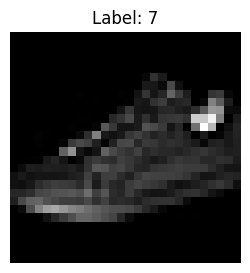

In [3]:
show_images(x[0], y[0])

In [4]:
#|export
import torch
import torch.nn as nn

In [5]:
im = x[0]
im.shape

torch.Size([1, 28, 28])

In [6]:
im[:,:4,:4]

tensor([[[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]]])

In [7]:
im[:,:4,:4]

tensor([[[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]]])

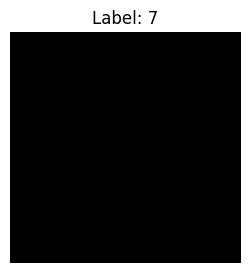

In [8]:
patch_h = patch_w = 7
show_images(im[:,:patch_h,:patch_w], y[0])

In [9]:
ch, h, w = im.shape
ch, h, w

(1, 28, 28)

In [10]:
patches = im.view(16, ch, patch_h, patch_w)
patches.shape

torch.Size([16, 1, 7, 7])

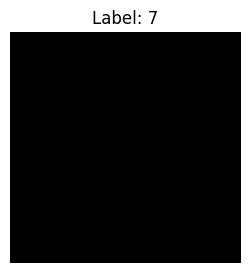

In [11]:
show_images(patches[0], y[0])

is the above implemementation correct for patching >

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Not quite! The issue is with how you're using `view()`. It's reshaping the tensor but not actually extracting the spatial patches correctly.

When you do `im.view(16, ch, patch_h, patch_w)`, it just reshapes the flattened data into that shape, but doesn't respect the 2D spatial structure of the image.

Look at your output - the first patch should show the top-left 7×7 region of the jacket, but it's showing something that looks like it's sampled from different parts.

To properly extract patches, you need to use either:
1. `unfold()` - which can extract sliding windows
2. Manual slicing with loops
3. `rearrange()` from einops library (very clean!)

Which approach would you like to try? The `unfold()` method is a good PyTorch-native solution.

In [12]:
unfold = nn.Unfold(kernel_size=(patch_h, patch_w), stride=patch_h)
patches = unfold(im[None,:])
patches.shape

torch.Size([1, 49, 16])

means 1 image, 49 values per patch (7×7), and 16 patches

In [13]:
patches = patches.view(16, 49)
patches.shape

torch.Size([16, 49])

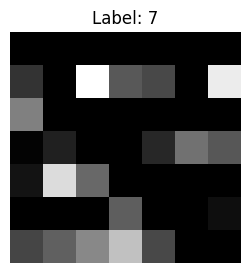

In [14]:
show_images(patches[0].view(7, 7), y[0])

Is the above correct>

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Yes! Now it's correct! 🎉

You can see that the first patch now shows the top-left corner of the jacket (mostly black background with a bit of the jacket edge), which is exactly what we'd expect.

Your patches tensor has shape `(16, 49)` - that's 16 patches, each flattened to 49 values. This is perfect for feeding into a linear projection layer.

Next step: you'll want to project these 49-dimensional vectors to your embedding dimension. Are you ready to create the patch embedding layer, or would you like to verify a few more patches first to make sure they look right?

NO i think you are wrong consider the output of `patch_h = patch_w = 7
show_images(im[:,:patch_h,:patch_w], y[0])`

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

You're absolutely right to question this! Let me look more carefully.

When you did `show_images(im[:,:patch_h,:patch_w], y[0])`, that showed you the actual top-left 7×7 patch using direct slicing: `im[:, 0:7, 0:7]`.

Now compare that image with what `patches[0].view(7, 7)` shows. Do they look the same to you, or different?

If they look different, then the unfold might be extracting patches in a different order than we expect. Can you check what the second image (from your earlier slicing) looks like versus what you're seeing now?

bith are diffweeent

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

You're right - they are different! That means `Unfold` is extracting or ordering the patches differently than we expected.

Let's debug this. Can you try showing a few more patches to see the pattern? For example:

```python
show_images(patches[1].view(7, 7), y[0])
```

And also manually slice the image to see what the second patch *should* be:

```python
show_images(im[:, 0:7, 7:14], y[0])  # top row, second patch
```

This will help us understand how `Unfold` is ordering the patches. What do you see?

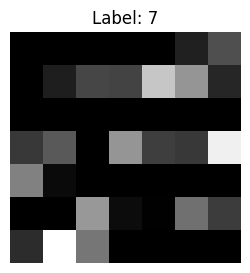

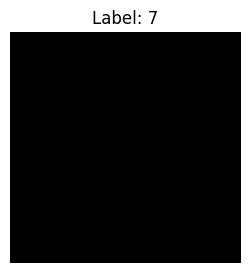

In [15]:
show_images(patches[1].view(7, 7), y[0])
show_images(im[:, 0:7, 7:14], y[0])

chech now

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Good catch! These are also different. The issue is that `Unfold` outputs patches in the format `(batch, channels * patch_h * patch_w, num_patches)`, but the patches need to be reshaped differently.

The problem is in how you're reshaping. Try this instead:

```python
patches = unfold(im[None,:])  # shape: (1, 49, 16)
patches = patches.transpose(1, 2).squeeze(0)  # shape: (16, 49)
```

This transposes before removing the batch dimension. Can you try this and check if `patches[0].view(7, 7)` now matches `im[:, 0:7, 7:14]`?

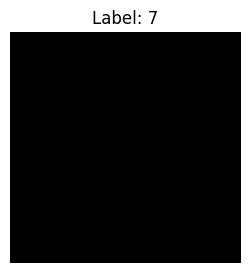

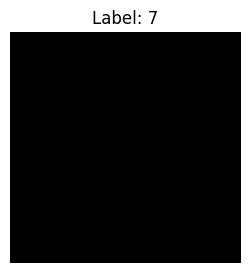

In [16]:
patches = unfold(im[None,:])  # shape: (1, 49, 16)
patches = patches.transpose(1, 2).squeeze(0)  # shape: (16, 49)
show_images(patches[1].view(7, 7), y[0])
show_images(im[:, 0:7, 7:14], y[0])

In [17]:
patches.shape

torch.Size([16, 49])

In [18]:
patches = patches[None,:] # adding batch dim
patches.shape

torch.Size([1, 16, 49])

## Pojection

Here's why: the attention mechanism expects all inputs to be in the same embedding dimension. Right now your patches are 49-dimensional vectors, but you need them to be in your chosen `embed_dim` (like 256 or 512).

The projection layer is just a simple linear layer:
```python
nn.Linear(49, embed_dim)
```

After projection, you'll also need to:
1. Add the [CLS] token
2. Add positional embeddings

![pasted_image_95c74ea9-bafe-44fc-9aef-099a9dc9fbfb.png](attachment:95c74ea9-bafe-44fc-9aef-099a9dc9fbfb)



In [19]:
embed_dim = 32
vis_proj = nn.Linear(49, embed_dim)


In [20]:
# vison embeddings
vis_emb = vis_proj(patches)
vis_emb.shape

torch.Size([1, 16, 32])

## final token

Done what to do next `[CLS]` token?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Perfect! Now you have your patch embeddings with shape `(1, 16, 32)`.

Next, you need to create a learnable `[CLS]` token. This is a special embedding that will be prepended to your sequence. After going through the transformer, you'll use this token's representation for classification.

You can create it as a learnable parameter:

```python
cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
```

Then you'll concatenate it to the beginning of your patch embeddings. How would you concatenate `cls_token` with `vis_emb` along the sequence dimension to get shape `(1, 17, 32)`?

In [21]:
import torch
cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
final_emb = torch.cat([cls_token, vis_emb], dim = 1)
final_emb.shape

torch.Size([1, 17, 32])

## Projection

As the paper suggest to use 1-D postional encoding. Is the idea behind it to convert the 2-D spatial tokens postions to 1D ?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Exactly! You've got the key idea.

Even though the image patches come from a 2D grid (4×4 in your case), the Vision Transformer treats them as a 1D sequence - just like how text tokens are sequential in GPT.

So the positional encoding is simply:
- Position 0: [CLS] token
- Position 1-16: the 16 patches in row-major order (top-left to bottom-right)

The transformer doesn't inherently know these came from a 2D spatial arrangement. The positional embeddings just tell it "this is position 0, this is position 1, etc."

Interestingly, the paper found that 1D positional embeddings work just as well as 2D ones (which would explicitly encode row/column info). The model learns the spatial relationships through the data.

How would you create these positional embeddings for 17 positions?

In [22]:
no_patches = 16
pos_emb = nn.Embedding(no_patches + 1, embed_dim) # map 17 positions -> embed_dim

pos = pos_emb(torch.arange(no_patches+1))
pos.shape


torch.Size([17, 32])

In [23]:
emb = final_emb + pos_emb(torch.arange(no_patches+1))
emb.shape

torch.Size([1, 17, 32])

Next the attention block?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Great progress! You now have your input ready for the transformer: `(1, 17, 32)`.

Since you've already built GPT-2 from scratch, you should be familiar with the self-attention mechanism. The good news is that ViT uses very similar transformer encoder blocks!

The main difference:
- **GPT-2** uses causal (masked) attention - tokens can only attend to previous tokens
- **ViT** uses bidirectional attention - each token can attend to all other tokens (like BERT)

Do you want to adapt your existing attention blocks from your GPT implementation, or would you like to build the ViT attention from scratch?


![pasted_image_f181f4b6-c23d-4adc-9ac8-63c4c0c21eaa.png](attachment:f181f4b6-c23d-4adc-9ac8-63c4c0c21eaa)


What does the papae suggests? ie no of attention head, type of Norm, and type of MLP with non linearity

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Great question! The ViT paper specifies:

**1. Normalization:** LayerNorm (same as GPT/BERT)

**2. Number of heads:** Depends on the model size:
- ViT-Base: 12 heads
- ViT-Large: 16 heads  
- ViT-Small: often 6-8 heads for smaller experiments

**3. MLP:** A 2-layer feedforward network with:
- Hidden dimension = 4× the embedding dimension
- **GELU** activation (not ReLU)

**4. Important:** The diagram shows LayerNorm is applied **before** each block (pre-norm), not after like the original Transformer paper.

For Fashion MNIST with `embed_dim=32`, you might want to start small. How many attention heads do you want to use? (Hint: `embed_dim` should be divisible by the number of heads)

Lets use 4 heads  and how many deocder block to stack on top of each other?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Perfect! 4 heads works well with `embed_dim=32` (each head gets 8 dimensions).

For the number of encoder blocks (not decoder - remember ViT uses encoder blocks like BERT, not decoder blocks like GPT), the paper suggests:
- ViT-Small: 12 layers
- ViT-Base: 12 layers
- ViT-Large: 24 layers

But for Fashion MNIST, which is a simpler dataset than ImageNet, you can start much smaller. Maybe 4-6 encoder blocks would be a good starting point.

How many layers do you want to try? Keep in mind you can always experiment with different depths later.

In [24]:
#|export
class AttentionHead(nn.Module):
    def __init__(self, config):
        super().__init__()

        assert config.embedding_dim % config.n_heads == 0
        self.head_dim = config.embedding_dim // config.n_heads

        self.Q_W = nn.Linear(config.embedding_dim, self.head_dim)
        self.K_W = nn.Linear(config.embedding_dim, self.head_dim)
        self.V_W = nn.Linear(config.embedding_dim, self.head_dim)

        self.dropout = nn.Dropout(p = config.dropout)

    def forward(self, x): #bs * seq_len * embedding_dim

        Q, K, V = self.Q_W(x), self.K_W(x), self.V_W(x)        #bs * seq_len * head_dim

        attn = Q @ K.transpose(-2, -1) /  self.head_dim ** 0.5         #bs * seq_len * head_dim @ bs * head_dim * seq_len -> bs * seq_len * seq_len

        attn = torch.softmax(attn, dim=-1)
        return self.dropout(attn @ V)         # bs * seq_len * seq_len @ bs * seq_len * head_dim -> bs * seq_len *  head_dim


In [25]:
#|export
class MultiHeadAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        assert config.embedding_dim % config.n_heads == 0 # config.n_heads * output of the embedding layer

        self.heads = nn.ModuleList([AttentionHead(config) for _ in range(config.n_heads)])
        self.dropout = nn.Dropout(p=config.dropout)
        self.linear_MHA = nn.Linear(config.embedding_dim, config.embedding_dim)
        self.layer_norm_MHA = nn.LayerNorm(config.embedding_dim)

    def forward(self, x): #bs * seq_len * embedding_dim
        x = self.layer_norm_MHA(x)
        head = torch.cat([head(x) for head in self.heads], dim=-1) #bs * seq_len * embedding_dim
        head = self.dropout(self.linear_MHA(head))                     #bs * seq_len * embedding_dim
        return head + x

### MLP

`x → LayerNorm → up_proj → GELU → down_proj → dropout → add residual`

In [26]:
#|export
class MLP(nn.Module):
    def __init__(self, config):
        super().__init__()

        self.dropout = nn.Dropout(p=config.dropout)
        self.up_proj = nn.Linear(config.embedding_dim, 4 * config.embedding_dim)
        self.down_proj = nn.Linear(4 *config.embedding_dim, config.embedding_dim)
        self.layer_norm_MLP = nn.LayerNorm(config.embedding_dim)
        self.gelu = nn.GELU(approximate='tanh')

    def forward(self, x): #bs * seq_len * embedding_dim
        pred = self.layer_norm_MLP(x)       #bs, seq_len, embedding_dim
        pred = self.up_proj(pred)           #bs, seq_len, 4 * embedding_dim
        pred = self.gelu(pred)
        pred = self.down_proj(pred)         #bs, seq_len, embedding_dim

        return self.dropout(pred) + x


### Final ViT model

In [27]:
class VIT(nn.Module):
    def __init__(self, config):
        super().__init__()

        self.blocks = nn.ModuleList(
            [
                nn.Sequential(MultiHeadAttention(config), MLP(config))
                for _ in range(config.n_layers)
            ])
        self.layer_norm = nn.LayerNorm(config.embedding_dim)
        self.lm_head = nn.Linear(config.embedding_dim, config.vocab_size)

    def forward(self, x):
        x = self.embed(x)
        for block in self.blocks:
            x = block(x)
        x = self.lm_head(self.layer_norm(x))
        return x[:,1,:] # rtuen cls token only

Check the VIT model

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Great work! Your VIT model is almost complete. A few things to check:

1. ✅ Stacking attention + MLP blocks correctly
2. ✅ Final LayerNorm before the classification head
3. ✅ Returning only the [CLS] token (position 0, not 1!)
4. ❓ The `self.embed(x)` method - you haven't defined this yet. This should do all the patch extraction, projection, adding [CLS] token, and positional embeddings that you coded earlier.

**Small bug:** `return x[:,1,:]` should be `return x[:,0,:]` since the [CLS] token is at position 0, not position 1.

Do you want to create the `embed` method that wraps all your patch embedding logic?

do i need another MLP head on top of CLS token?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Good question! It depends on what you mean by "MLP head."

Your current code has `self.lm_head = nn.Linear(config.embedding_dim, config.vocab_size)` which is a single linear layer mapping from the [CLS] token's embedding to the number of classes (10 for Fashion MNIST).

The ViT paper uses just this single linear layer for classification. However, some implementations add a small MLP (like 1-2 hidden layers) before the final classification layer, which can sometimes help performance.

For Fashion MNIST, a single linear layer should work fine to start. You can always experiment with adding a small MLP later if needed.

Does that answer your question, or would you like to discuss adding an MLP head?

In [28]:
class VIT(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.unfold = nn.Unfold(kernel_size=config.patch_dim//2, stride=config.patch_dim//2)
        self.image_projection = nn.Linear(config.patch_dim, config.embedding_dim)

        self.cls_token = nn.Parameter(torch.randn(1, 1, config.embedding_dim))

        self.pos_embedding = nn.Embedding(config.no_patches + 1, config.embedding_dim)

        self.register_buffer('pos_range', torch.arange(config.no_patches + 1))
        self.blocks = nn.ModuleList(
            [
                nn.Sequential(MultiHeadAttention(config), MLP(config))
                for _ in range(config.n_layers)
            ])
        self.layer_norm = nn.LayerNorm(config.embedding_dim)
        self.lm_head = nn.Linear(config.embedding_dim, config.vocab_size)

    def forward(self, x):                 # bs,ch,h,w
        bs,ch, h,w = x.shape

        x = self.unfold(x)      # bs,ch,patch_h*patch_w, no_patch
        x.transpose_(-2,-1)

        x = self.image_projection(x)
        x = torch.cat([self.cls_token, x], dim=1) #bs,ch,no_patch+1,patch_h*patch_w

        x = x + self.pos_embedding(self.pos_range)
        for block in self.blocks:
            x = block(x)
        x = self.lm_head(self.layer_norm(x))
        return x[:,0,:] # rtuen cls token only

Check the finalimplementaion

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Nice work! Your VIT implementation looks solid. A few observations:

1. ✅ Patch extraction with `unfold`
2. ✅ Transpose to get correct shape
3. ✅ Image projection
4. ✅ [CLS] token concatenation
5. ✅ Positional embeddings with registered buffer (smart!)
6. ✅ Transformer blocks
7. ✅ Final LayerNorm and classification head
8. ✅ Returning [CLS] token at position 0

**One small issue:** Line where you concatenate `cls_token` - it needs to be expanded for the batch size. Currently `self.cls_token` has shape `(1, 1, embed_dim)`, but when your batch size is 64, you need `(64, 1, embed_dim)`.

Try: `torch.cat([self.cls_token.expand(bs, -1, -1), x], dim=1)`

Also, double-check your `config.patch_dim` - it should be `patch_h * patch_w = 49` for the projection, not `patch_h = 7`.

Want to test it with your Fashion MNIST batch to see if the shapes work correctly?

so the `self.cls_token = nn.Parameter(torch.randn(1, 1, config.embedding_dim))` should have bs in it ?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

No, you should keep `self.cls_token` as `(1, 1, embed_dim)` - that's correct!

The `cls_token` is a **learnable parameter** that's the same for all images. You don't want separate parameters for each batch element.

The issue is just in the `forward` method when you concatenate it. You need to **expand** (or repeat) it to match the batch size at that moment:

```python
torch.cat([self.cls_token.expand(bs, -1, -1), x], dim=1)
```

This broadcasts the same [CLS] token across all batch elements without creating new parameters.

Does that distinction make sense?

but it will create different class for different items right other wise there will be only one [cls] token?


##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Great question! This is an important distinction.

You're right that after expanding, each image in the batch gets its own [CLS] token, but they all **start with the same initial values** (from the one learnable parameter).

Here's the key: After going through the transformer blocks, each image's [CLS] token will be **different** because:
- Each image has different patches
- The attention mechanism mixes information from those patches into the [CLS] token
- So the final [CLS] representation is unique for each image

Think of it like this: all images start with the same [CLS] token, but after "attending" to their own unique patches, each [CLS] token becomes specialized for that specific image.

Does this clarify how one parameter can lead to different classifications for different images?

so by using expand we are extedning the cls tokens to 64 images. But here my wuestion but only 1 is saved in the model right?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Exactly! You've got it.

**Only 1** `cls_token` parameter (with shape `(1, 1, embed_dim)`) is saved in the model and gets updated during training.

The `expand` operation just creates a **view** - it doesn't copy or create new parameters. During backpropagation, the gradients from all 64 images flow back and get **accumulated** into that single shared parameter.

So:
- Storage: 1 learnable [CLS] token
- During forward pass: expanded to match batch size
- During backward pass: gradients from all batch items update the same single parameter

This is actually efficient - one shared [CLS] token learns to gather relevant information from any image!

Does that clear it up?

By following broadcasting rule it will broadcasted proberly right ?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Not quite! The `expand` method doesn't follow automatic broadcasting rules - you need to call it explicitly.

If you just do `torch.cat([self.cls_token, x], dim=1)` where `self.cls_token` is `(1, 1, embed_dim)` and `x` is `(bs, 16, embed_dim)`, PyTorch will try to concatenate them but the batch dimensions won't match properly, and you'll get a shape mismatch error.

That's why you need to explicitly expand: `self.cls_token.expand(bs, -1, -1)` to make it `(bs, 1, embed_dim)` before concatenating.

Want to test your model now to see if the shapes work correctly with a batch from your dataloader?

In [29]:
# Dummy tensors
cls_token = torch.randn(1, 1, 32)  # shape: (1, 1, 32)
patches = torch.randn(64, 16, 32)   # shape: (64, 16, 32)

# Without expand - this will fail:
#torch.cat([cls_token, patches], dim=1)  # Error! Batch dims don't match

# With expand - this works:
cls_expanded = cls_token.expand(64, -1, -1)  # shape: (64, 1, 32)
result = torch.cat([cls_expanded, patches], dim=1)  # shape: (64, 17, 32)

print(result.shape)

torch.Size([64, 17, 32])


In [30]:
#|export
class VIT(nn.Module):
    def __init__(self, config):
        super().__init__()
        assert config.patch_h == config.patch_w
        assert config.h % config.patch_h == 0 and config.w % config.patch_w == 0
        assert config.no_patches == (config.h // config.patch_h) * (config.w // config.patch_w)

        self.unfold = nn.Unfold(kernel_size=config.patch_h, stride=config.patch_h)
        self.image_projection = nn.Linear(config.patch_dim, config.embedding_dim)

        self.cls_token = nn.Parameter(torch.randn(1, 1, config.embedding_dim))

        self.pos_embedding = nn.Embedding(config.no_patches + 1, config.embedding_dim)

        self.register_buffer('pos_range', torch.arange(config.no_patches + 1))
        self.blocks = nn.ModuleList(
            [
                nn.Sequential(MultiHeadAttention(config), MLP(config))
                for _ in range(config.n_layers)
            ])
        self.layer_norm = nn.LayerNorm(config.embedding_dim)
        self.lm_head = nn.Linear(config.embedding_dim, config.vocab_size)

        # init
        self._init_weights()

    def forward(self, x):                 # bs,ch,h,w
        bs,ch,h,w = x.shape

        x = self.unfold(x)      # bs,ch,patch_h*patch_w, no_patch
        x.transpose_(-2,-1)

        x = self.image_projection(x)
        x = torch.cat([self.cls_token.expand(bs,-1,-1), x], dim=1) #bs,ch,no_patch+1,patch_h*patch_w

        x = x + self.pos_embedding(self.pos_range)
        for block in self.blocks:
            x = block(x)
        x = self.lm_head(self.layer_norm(x))
        return x[:,0,:] # rtuen cls token only

    def _init_weights(self):
        """Init"""
        for name, module in self.named_modules():
            if isinstance(module, nn.Linear):
                std = 0.02
                module.weight.data.normal_(mean=0.0, std=std)
                if module.bias is not None:
                    module.bias.data.zero_()

            elif isinstance(module, nn.Embedding):
                module.weight.data.normal_(mean=0.0, std=0.02)

    def decay_params(self):
        """
        get decay params
        """
        no_decay_params, decay_params = [], []
        for name, param in self.named_parameters():
            if 'bias' in name or 'norm' in name or 'embed' in name:
                no_decay_params.append(param)
            else:
                decay_params.append(param)

        return decay_params, no_decay_params

In [31]:
#|export
class Config:
    # Image
    h = 28
    w = 28

    # Patch settings
    patch_h = 7
    patch_w = 7
    patch_dim = patch_h * patch_w
    no_patches = (h // patch_h) * (w // patch_w)

    # Model architecture
    embedding_dim = 64
    n_heads = 4
    n_layers = 6

    # Regularization
    dropout = 0.1

    # Classification
    vocab_size = 10  # 10 classes for Fashion MNIST

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    dtype = torch.bfloat16 if torch.cuda.is_available() and torch.cuda.get_device_capability()[0] >= 8 else torch.float16 # Use bfloat16 on Ampere+ GPUs, otherwise use float16

    epochs = 20
    max_steps = len(dl['train']) * epochs
    warm_steps = int(max_steps * 0.1)

    max_lr = 5e-4
    min_lr = 1e-4
config = Config()

In [32]:
#|export
#loss function
loss_func = nn.CrossEntropyLoss()

In [33]:
vis_model = VIT(config=config)
pred = vis_model(x)
pred.shape

torch.Size([64, 10])

In [34]:
loss_func(pred,y)

tensor(2.3281, grad_fn=<NllLossBackward0>)

## Cosine learning Sceduler

In [35]:
#|export
import math
def get_cosine_lr(
    step,
    warmup_steps=config.warm_steps,
    max_steps=config.max_steps,
    max_lr=config.max_lr,
    min_lr=config.min_lr
    ):
    if step < warmup_steps:
        return min_lr + (max_lr - min_lr) * step / warmup_steps
    elif step < max_steps:
        progress = (step - warmup_steps) / (max_steps - warmup_steps)
        return min_lr + 0.5 * (max_lr - min_lr) * (1 + math.cos(math.pi * progress))
    else:
        return min_lr


## Optimizer

In [36]:
#|export
from torch.optim import AdamW
class Optim:
    def __init__(self, model, config):
        decay_params, no_decay_params = model.decay_params() # extract deacayable and non deacayable params

        self.optim = AdamW([
            {'params': decay_params, 'weight_decay': 0.1},
            {'params': no_decay_params, 'weight_decay': 0.0}
        ], lr=config.min_lr)

    def config_lr(self, step):
        for param_group in self.optim.param_groups:
            param_group['lr'] = get_cosine_lr(step)

    def step(self): self.optim.step()

    def zero(self): self.optim.zero_grad()

## Training

In [37]:
#|export
from torch.nn.utils import clip_grad_norm_
import torch.nn as nn
loss_func = nn.CrossEntropyLoss()
def train(model):
    model = model.to(config.device)

    optimizer = Optim(model, config)
    log = []
    step = 0
    for epoch in range(config.epochs):
        model.train()
        train_loss, no_train = 0, 0

        for x, y in dl['train']: # Iterate directly over
            step += 1
            no_train += 1

            x, y = x.to(config.device), y.to(config.device)           # move to device

            optimizer.config_lr(step)                                           # set lr for each step
            optimizer.zero()

            with torch.autocast(device_type=config.device, dtype=config.dtype):
              logits = model(x)

              loss = loss_func(logits, y)

            loss.backward()

            clip_grad_norm_(model.parameters(), 1.0) # to clip gradients

            optimizer.step()

            train_loss += loss.item()

        model.eval()
        val_loss, no_valid = 0, 0
        total_correct = 0
        total_samples  = 0
        with torch.no_grad(), torch.autocast(device_type=config.device, dtype=config.dtype):
            for x, y in dl['valid']:
                no_valid += 1

                x, y = x.to(config.device), y.to(config.device)

                logits = model(x)
                loss = loss_func(logits, y)

                predicted = logits.softmax(-1).argmax(-1)
                total_correct += (predicted == y).sum().item()

                val_loss += loss.item()
                total_samples += y.size(0)

        accurecy = total_correct / total_samples
        print(f"{epoch} -> {train_loss/no_train:.4f} : {val_loss/no_valid:.4f} : {accurecy}")
        log.append({"epoch":epoch, "train_loss":train_loss/no_train, "valid_loss":val_loss/no_valid, "accurecy":accurecy})
    return log


In [38]:
dic = {}
for i in [16, 32, 64, 128, 256]:
    config.embedding_dim = i
    vis_model = VIT(config=config)
    print(f"with embeddings {i}")
    print("---"*20)
    dic[i] = train(vis_model)
    print("---"*20)
    del vis_model

with embeddings 16
------------------------------------------------------------
0 -> 1.8835 : 1.4794 : 0.5305
1 -> 1.1734 : 0.9376 : 0.6425
2 -> 0.7867 : 0.6789 : 0.7631
3 -> 0.6251 : 0.5803 : 0.7869
4 -> 0.5585 : 0.5340 : 0.8108
5 -> 0.5173 : 0.5054 : 0.8141
6 -> 0.4917 : 0.4971 : 0.8202
7 -> 0.4744 : 0.4741 : 0.8299
8 -> 0.4579 : 0.4866 : 0.827
9 -> 0.4437 : 0.4494 : 0.8417
10 -> 0.4324 : 0.4379 : 0.8456
11 -> 0.4216 : 0.4241 : 0.8497
12 -> 0.4138 : 0.4247 : 0.8485
13 -> 0.4072 : 0.4222 : 0.8528
14 -> 0.3988 : 0.4117 : 0.8549
15 -> 0.3949 : 0.4130 : 0.8551
16 -> 0.3920 : 0.4046 : 0.8553
17 -> 0.3883 : 0.4007 : 0.8579
18 -> 0.3848 : 0.4011 : 0.8578
19 -> 0.3833 : 0.4058 : 0.8562
------------------------------------------------------------
with embeddings 32
------------------------------------------------------------
0 -> 1.5602 : 1.0076 : 0.6468
1 -> 0.7871 : 0.6391 : 0.7735
2 -> 0.5694 : 0.5186 : 0.8147
3 -> 0.4818 : 0.4631 : 0.8371
4 -> 0.4382 : 0.4353 : 0.8415
5 -> 0.4062 : 0.4330

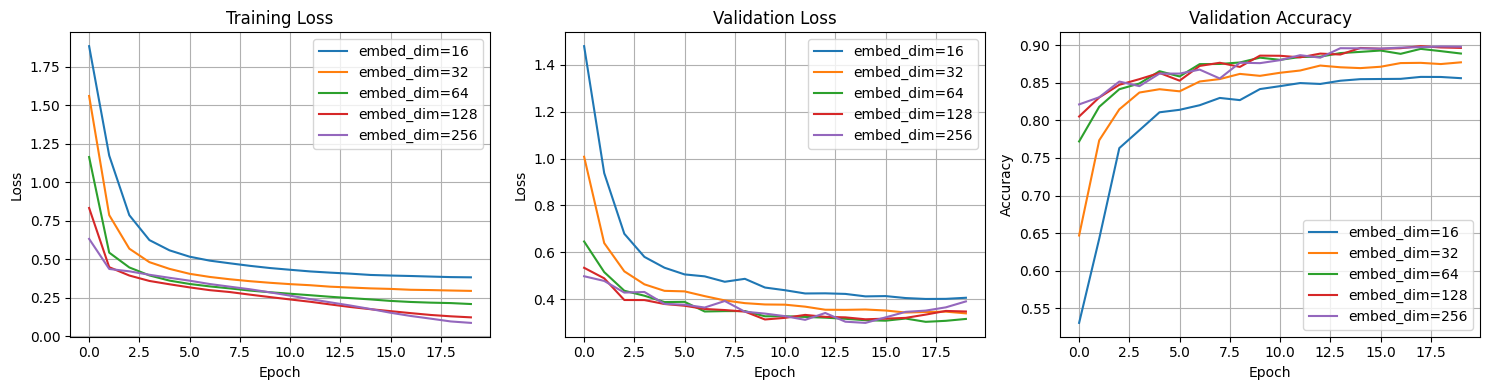

In [40]:

import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for embed_dim, logs in dic.items():
    epochs = [log['epoch'] for log in logs]
    train_losses = [log['train_loss'] for log in logs]
    valid_losses = [log['valid_loss'] for log in logs]
    accuracies = [log['accurecy'] for log in logs]

    axes[0].plot(epochs, train_losses, label=f'embed_dim={embed_dim}')
    axes[1].plot(epochs, valid_losses, label=f'embed_dim={embed_dim}')
    axes[2].plot(epochs, accuracies, label=f'embed_dim={embed_dim}')

axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training Loss')
axes[0].legend()
axes[0].grid(True)

axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_title('Validation Loss')
axes[1].legend()
axes[1].grid(True)

axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Accuracy')
axes[2].set_title('Validation Accuracy')
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.show()